In [4]:
import numpy as np
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, norm
import gurobipy as gp
from gurobipy import GRB
from IPython.display import display, Math
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product, combinations
from scipy.spatial.distance import cdist

## Matching Approach Simulation

### Setup 1

##### Modify the balancing weight function to make the optimized weight a binary output of {0,1}

#### Limitations

After changing the decision variable weight $w_i$ as binary number and objective function into maximize the sample size, if I continue follow the weight balancing constraints, it means force the selected subset to exactly replicate the entire sample’s sum of covariates in the plus and minus group, the entire sample’s sum in the minus group, etc. This will be most likely infeasible if $w_i \in{0,1}$. It cannot pick a strict subset that exactly reproduces the entire sample’s sums.

I allowed a tolerance on the SMD of the lhs and rhs for every balancing constraints. I calculated the SMD of the lhs and rhs of every balancing constraints and let them smaller than this tolerance value. 

For the heterogeneous constraints, simply allowing a tolerance would lead to NaNs outputs or “all-in” solutions with large SMD when I vary tol. I think it is because of the division by zero or near‐zero standard deviations. I am dividing by std_plus and std_minus, and if any of these standard deviations are zero or extremely small, the expression $  \frac{\text{lhs} - \text{target}}{\text{std\_plus}} \leq \text{tol} $ can blow up numerically or become NaN. 

So I added a eps term and set it to be 0.6 that I only calculate the SMD when the standard deviations of plus and minus groups are greater than this number. If the standard deviations are smaller than this number, I skip those constraints because a small and near-zero standard deviation means this group is already balanced and there is no need for balancing constraints.



In [5]:
np.random.seed(123)

D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Estimate tau_1, tau_2, tau_3 under each outcome model.

# implements the logistic function for probability calculations
def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

# assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
def generate_treatments(X):
    # initializes a Z matrix (N x K) where each row represents an individual's treatment status.
    Z = np.zeros((X.shape[0], K)) 
    # computes treatment probabilities using logistic regression.
    p1 = logistic(X @ beta1)
    # assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    # generates all 2^K possible combinations of treatments, each treatment can be -1 or +1
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    # creates contrast vectors for each treatment
    g = {}
    for k in range(K):
        # assigns +1 if the treatment is +1, otherwise assigns -1
        gk = np.where(combos[:, k] == +1, +1, -1) 
        g[k+1] = gk

    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3), the matrix of all possible treatment assignments

# generate true main effects
def true_main_effects(Yfn, combos=Z_all):
    # generates a large population (bigN = 200000) for estimating expected treatment effects
    bigN = 200000  
    # generates samples from a multivariate normal distribution with mean vector [0, 0, 0, 0, 0]
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN) 
    # match the simulation in section 5.1 where mu = (0.1, 0.1, 0.1, 0, 0).T
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1
    
    # store expected outcomes for each treatment combination
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        # expands z across bigN rows
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        # computes expected outcomes for treatment z using function Yfn(Xbig, Zbig).
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        # stores the mean outcome for each treatment condition
        EYZ[i] = np.mean(Evals)

    tau = {}
    factor = 1 / (2 ** (K - 1))  # Compute the factor for scaling
    for k in range(1, K+1):
        # retrieves contrast vector for the k-th treatment.
        gk = g_dict[k]
        # computes the main effect estimate
        #tau_k = np.mean(gk * EYZ)  
        tau_k = factor * np.dot(gk, EYZ)  
        tau[k] = tau_k
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="heterogeneous":
        meanY = Y_model_het(X, Z)
    elif model=="misspecified":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + np.random.randn(len(X))  # add normal(0,1)

def solve_matching_additive(X, Z, tol=0.1):

    N, D = X.shape
    K = Z.shape[1]

    # Define group membership indicators
    Aplus = np.where(Z > 0, 1.0, 0.0)
    Aminus = 1.0 - Aplus

    # Full sample sums (for converting sums into means)
    sumX = np.sum(X, axis=0)
    # Standard deviation for each covariate (population std)
    std_X = np.std(X, axis=0, ddof=0)

    # Build the model
    model = gp.Model("AdditiveBalance_binary")
    model.setParam('OutputFlag', 0)

    # Decision variables: w_i in {0,1}
    w_vars = model.addVars(N, vtype=GRB.BINARY, name="w")
    # Objective: maximize the number of selected units
    model.setObjective(gp.quicksum(w_vars[i] for i in range(N)), GRB.MAXIMIZE)

    # Relaxed balancing constraints for each factor and covariate dimension:
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i] * Aplus[i, k_] * X[i, d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i] * Aminus[i, k_] * X[i, d_] for i in range(N))
            # Instead of exact equality of sums, we require the difference in means to be within tol std deviations:
            model.addConstr((lhs_plus/N - sumX[d_]/N) / std_X[d_] <= tol)
            model.addConstr((lhs_plus/N - sumX[d_]/N) / std_X[d_] >= -tol)
            model.addConstr((lhs_minus/N - sumX[d_]/N) / std_X[d_] <= tol)
            model.addConstr((lhs_minus/N - sumX[d_]/N) / std_X[d_] >= -tol)

    # # Exact constraints on the number of selected units per factor group
    # for k_ in range(K):
    #     lhs_plus  = gp.quicksum(w_vars[i] * Aplus[i, k_] for i in range(N))
    #     lhs_minus = gp.quicksum(w_vars[i] * Aminus[i, k_] for i in range(N))
    #     model.addConstr(lhs_plus == N)
    #     model.addConstr(lhs_minus == N)

    # Relaxed interaction constraints:
    # For interactions up to order K_prime (here set as min(K,2) as in your original code)
    K_prime = min(K, 3)
    Z_all = np.array(list(product([-1, 1], repeat=K)))
    factor = 1 / (2**(K - 1))
    for k_size in range(2, K_prime + 1):
        for J in combinations(range(K), k_size):
            # Compute the interaction for each individual:
            Z_interaction = np.prod(Z[:, list(J)], axis=1)
            lhs = gp.quicksum(w_vars[i] * Z_interaction[i] for i in range(N))
            # Compute the target value:
            g_interaction = np.prod(Z_all[:, list(J)], axis=1)
            rhs = factor * np.sum(g_interaction)
            # Compute standard deviation of the interaction variable (over full sample)
            std_interaction = np.std(Z_interaction, ddof=0)
            # Relax the equality constraint using tol (scaled back to the sum scale)
            model.addConstr((lhs/N - rhs/N)/ std_interaction <= tol)
            model.addConstr((lhs/N - rhs/N)/ std_interaction <= tol)
            
    # Solve the model
    model.optimize()
    if model.status != GRB.OPTIMAL:
        #print("Binary additive-balance model infeasible or no optimal solution found.")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt


def solve_matching_heterogeneous(X, Z, tol=1.0):
    N, D = X.shape
    K = Z.shape[1]

    model = gp.Model("HeteroBinary")
    model.setParam('OutputFlag', 0)

    # Decision variables: w_i in {0,1}
    w_vars = model.addVars(N, vtype=GRB.BINARY, name="w")
    model.setObjective(gp.quicksum(w_vars[i] for i in range(N)), GRB.MAXIMIZE)

    # Build basis functions (intercept and covariates)
    basis_vals = [np.ones(N)]
    for d_ in range(D):
        basis_vals.append(X[:, d_])
    # J_list for treatment factors (using only main effects here, can be extended)
    J_list = [()] + [(j,) for j in range(K)]
    n_s = len(basis_vals)
    n_J = len(J_list)

    # Precompute Qvals
    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J_ in enumerate(J_list):
        if len(J_) == 0:
            Zp = np.ones(N)
        else:
            Zp = np.prod(Z[:, list(J_)], axis=1)
        for s_ in range(n_s):
            Qvals[:, s_, j_idx] = basis_vals[s_] * Zp

    # Compute target_plus and target_minus as in your original code.
    # (For brevity, we assume the rest of your code computing target_plus/target_minus remains unchanged.)
    Aplus = np.where(Z > 0, 1.0, 0.0)
    Aminus = 1.0 - Aplus
    from itertools import product
    Z_all = np.array(list(product([-1, 1], repeat=K)))
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for z_index, z_ in enumerate(Z_all):
        for j_idx, J_ in enumerate(J_list):
            z_prod = np.prod(z_[list(J_)])  # product for the given combination
            for s_ in range(n_s):
                bigQ[z_index, s_, j_idx] = z_prod * np.sum(basis_vals[s_])
    factor = 1.0 / (2.0**(K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))
    for k_ in range(K):
        for z_index, z_ in enumerate(Z_all):
            if z_[k_] == +1:
                coeff_plus = 1.0
                coeff_minus = 0.0
            else:
                coeff_plus = 0.0
                coeff_minus = 1.0
            for s_ in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k_, s_, j_idx] += factor * coeff_plus * bigQ[z_index, s_, j_idx]
                    target_minus[k_, s_, j_idx] += factor * coeff_minus * bigQ[z_index, s_, j_idx]

    # Relaxed balance constraints: For each factor k, each basis function index s, and each treatment grouping j:
    for k_ in range(K):
        for s_ in range(n_s):
            for j_idx in range(n_J):
                lhs_plus = gp.quicksum(Aplus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i] for i in range(N))
                lhs_minus = gp.quicksum(Aminus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i] for i in range(N))
                # Compute the standard deviation (over the full sample) of the corresponding terms:
                values_plus = Aplus[:, k_] * Qvals[:, s_, j_idx]
                std_plus = np.std(values_plus, ddof=0)
                values_minus = Aminus[:, k_] * Qvals[:, s_, j_idx]
                std_minus = np.std(values_minus, ddof=0)
                # Instead of enforcing equality, require the absolute difference is within tol * std * N.
                eps = 0.6
                # if std_plus < eps:
                #     # Either skip or do exact equality. Here we do "exact" for illustration:
                #     model.addConstr(lhs_plus == target_plus[k_, s_, j_idx])
                if std_plus >= eps:
                    #  (lhs_plus/N - target_plus/N) / std_plus <= tol
                    model.addConstr((lhs_plus / N - target_plus[k_, s_, j_idx] / N) / std_plus <=  tol)
                    model.addConstr((lhs_plus / N - target_plus[k_, s_, j_idx] / N) / std_plus >= -tol)

                # If std_minus < eps, skip the "minus" constraints
                if std_minus >= eps:
                    model.addConstr((lhs_minus / N - target_minus[k_, s_, j_idx] / N) / std_minus <=  tol)
                    model.addConstr((lhs_minus / N - target_minus[k_, s_, j_idx] / N) / std_minus >= -tol)
                # else do nothing for minus side

    # Solve the model
    model.optimize()
    if model.status != GRB.OPTIMAL:
        #print("Binary heterogeneous-balance model infeasible or no optimal solution found.")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

    
#  Do an naive difference in means for each factor to estimate the factorial effect
def estimate_main_effects_matched(Y, Z, match_vec):
    # Weighted means become simple means if match_vec is 0/1
    # tau_k = mean(Y | Z_k=+1 & matched) - mean(Y | Z_k=-1 & matched)
    tau_est_matched = {}
    for k_ in range(K):
        plus_mask  = (Z[:, k_] == +1) & (match_vec == 1)
        minus_mask = (Z[:, k_] == -1) & (match_vec == 1)
        if np.sum(plus_mask) < 1 or np.sum(minus_mask) < 1:
            tau_est_matched[k_+1] = np.nan
        else:
            mean_plus  = np.mean(Y[plus_mask])
            mean_minus = np.mean(Y[minus_mask])
            tau_est_matched[k_+1] = mean_plus - mean_minus
    return tau_est_matched


# Getting the standardized mean difference (SMD) for each factor k and each covariate dimension d
def get_covariate_balance_matched(X, Z, selection):
    sd_X = np.std(X, axis=0, ddof=1)
    smd = np.zeros((K, D))
    for k in range(K):
        plus_mask = (Z[:, k] == +1) & (selection == 1)
        minus_mask = (Z[:, k] == -1) & (selection == 1)
        if np.sum(plus_mask) > 0:
            mean_plus = np.mean(X[plus_mask], axis=0)
        else:
            mean_plus = np.full(X.shape[1], np.nan)
        if np.sum(minus_mask) > 0:
            mean_minus = np.mean(X[minus_mask], axis=0)
        else:
            mean_minus = np.full(X.shape[1], np.nan)
        diff = mean_plus - mean_minus
        smd[k, :] = diff / (sd_X + 1e-15)
    return smd


# print an array with 5 significant figures per float.
def print_array_5sig(arr):
    with np.printoptions(formatter={'float_kind': lambda x: f"{x:.5g}"}):
        print(arr)

def run_simulation_matching(n_sims=10, N=1000, model_type="additive", tol_add=1.0, tol_het=1.0):

    if model_type == "additive":
        Yfn = Y_model_additive
    elif model_type == "heterogeneous":
        Yfn = Y_model_het
    elif model_type == "misspecified":
        Yfn = Y_model_mis
    else:
        raise ValueError("Unknown model_type")

    true_tau = true_main_effects(Yfn)
    matched_taus_add = []
    matched_taus_het = []
    smds_add = []
    smds_het = []
    ess_add = []
    ess_het = []

    for sim in range(n_sims):
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        Z_   = generate_treatments(Xraw)
        Y_   = simulate_Y(Xraw, Z_, model=model_type)

        # Solve for 0/1 match vectors
        matchA = solve_matching_additive(Xraw, Z_, tol=tol_add)
        matchH = solve_matching_heterogeneous(Xraw, Z_, tol=tol_het)
        print(matchA)
        print(matchH)

        if matchA is None:
            matched_taus_add.append([np.nan, np.nan, np.nan])
            smds_add.append(np.full((K, D), np.nan))
        else:
            tA = estimate_main_effects_matched(Y_, Z_, matchA)
            matched_taus_add.append([tA[1], tA[2], tA[3]])
            ess_add = np.sum(matchA)
            smd_add = get_covariate_balance_matched(Xraw, Z_, matchA)
            smds_add.append(smd_add)

        if matchH is None:
            matched_taus_het.append([np.nan, np.nan, np.nan])
            smds_het.append(np.full((K, D), np.nan))
        else:
            tH = estimate_main_effects_matched(Y_, Z_, matchH)
            matched_taus_het.append([tH[1], tH[2], tH[3]])
            ess_het = np.sum(matchH)
            smd_het = get_covariate_balance_matched(Xraw, Z_, matchH)
            smds_het.append(smd_het)

    # Convert to arrays
    matched_taus_add = np.array(matched_taus_add)
    matched_taus_het = np.array(matched_taus_het)
    smds_add = np.array(smds_add)  
    smds_het = np.array(smds_het) 
    ess_add = np.array(ess_add)
    ess_het = np.array(ess_het)

    def rmse(vals, truth):
        return np.sqrt(np.nanmean((vals - truth)**2, axis=0))

    # shape (n_sims, 3) 
    add_rmse = rmse(matched_taus_add, [true_tau[1], true_tau[2], true_tau[3]])
    het_rmse = rmse(matched_taus_het, [true_tau[1], true_tau[2], true_tau[3]])

    mean_smd_add = np.nanmean(smds_add, axis=0)  
    mean_smd_het = np.nanmean(smds_het, axis=0)  

    return {
        "true_tau": true_tau,
        "rmse_matched_additive": add_rmse,
        "rmse_matched_hetero":   het_rmse,
        'mean_smd_add': mean_smd_add,
        'mean_smd_het': mean_smd_het,
        'ess_add': ess_add,
        'ess_het': ess_het
    }


In [ ]:
if __name__=="__main__":
    simulation_results_dict = {}
    for mtype in ["additive","heterogeneous","misspecified"]:
        res = run_simulation_matching(n_sims=130, N=200, model_type=mtype, tol_add=0.01, tol_het=0.025)
        simulation_results_dict[mtype] = res
        # Print results
        print(f"\nModel type = {mtype}")
        print("True main effects:", res['true_tau'])
        print("RMSE (weighting add.):",     res['rmse_matched_additive'])
        print("RMSE (Weight Hetero.):",  res['rmse_matched_hetero'])
        print("\nMean SMD (Additive Weights):")
        print_array_5sig(res['mean_smd_add'])
        print("\nMean SMD (Hetero Weights):")
        print_array_5sig(res['mean_smd_het'])
        print("Effective sample size(additive):", res['ess_add'])
        print("Effective sample size(hetero):", res['ess_het'])


Set parameter Username
Set parameter LicenseID to value 2622621
Academic license - for non-commercial use only - expires 2026-02-16
None
None
None
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0

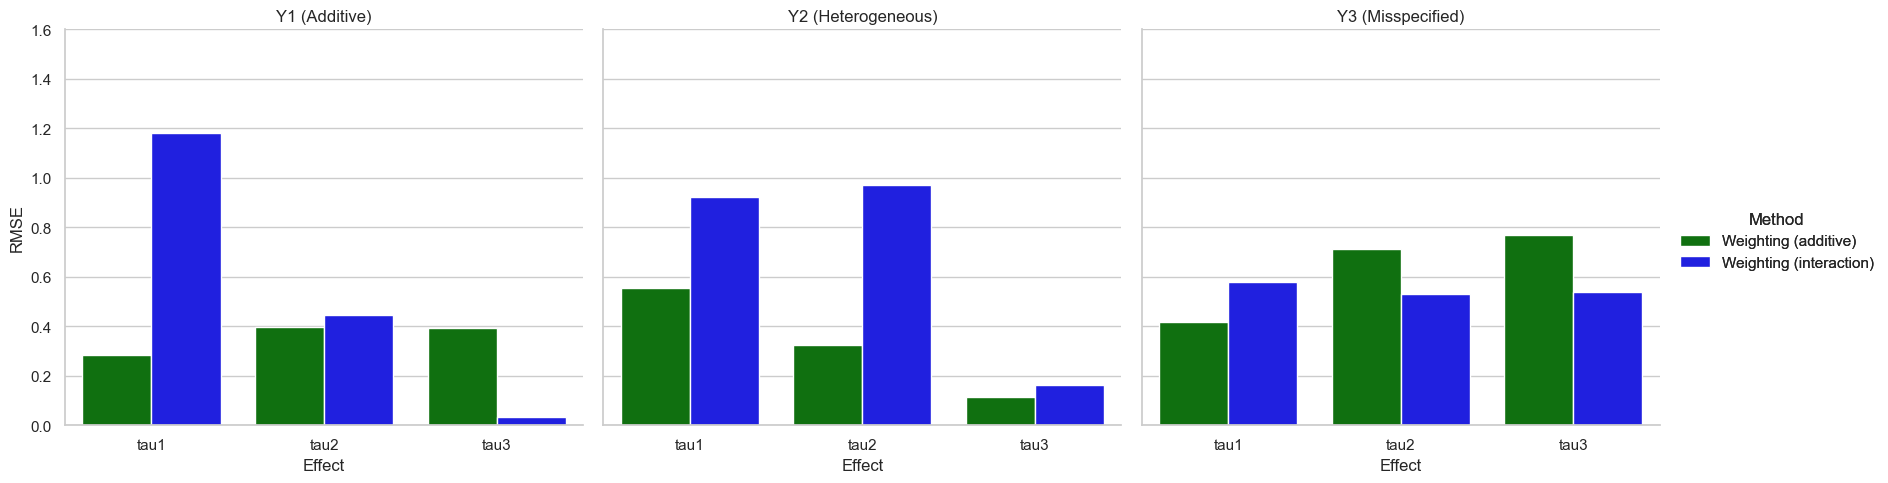

In [7]:
def plot_rmse_comparison_approx(results_dict):
    effects = ['tau1', 'tau2', 'tau3']
    methods = ["rmse_matched_additive", "rmse_matched_hetero"]
    method_names = ["Weighting (additive)", "Weighting (interaction)"]
    models = {"additive": "Y1 (Additive)", "heterogeneous": "Y2 (Heterogeneous)", "misspecified": "Y3 (Misspecified)"}
    
    data = []
    for model_type, results in results_dict.items():
        for method, method_name in zip(methods, method_names):
            for i, effect in enumerate(effects):
                data.append([models[model_type], effect, results[method][i], method_name])

    df = pd.DataFrame(data, columns=["Outcome Model", "Effect", "RMSE", "Method"])
    
    # Set style
    sns.set(style="whitegrid")

    # Create FacetGrid bar plot
    g = sns.catplot(
        data=df,
        x="Effect",
        y="RMSE",
        hue="Method",
        col="Outcome Model",
        kind="bar",
        palette=['green', 'blue'],
        height=5,
        aspect=1
    )

    g.set_axis_labels("Effect", "RMSE")
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=0)
    g.add_legend(title="Method")
    g.set(ylim=(0, 1.6))
    
    plt.show()

plot_rmse_comparison_approx(simulation_results_dict)

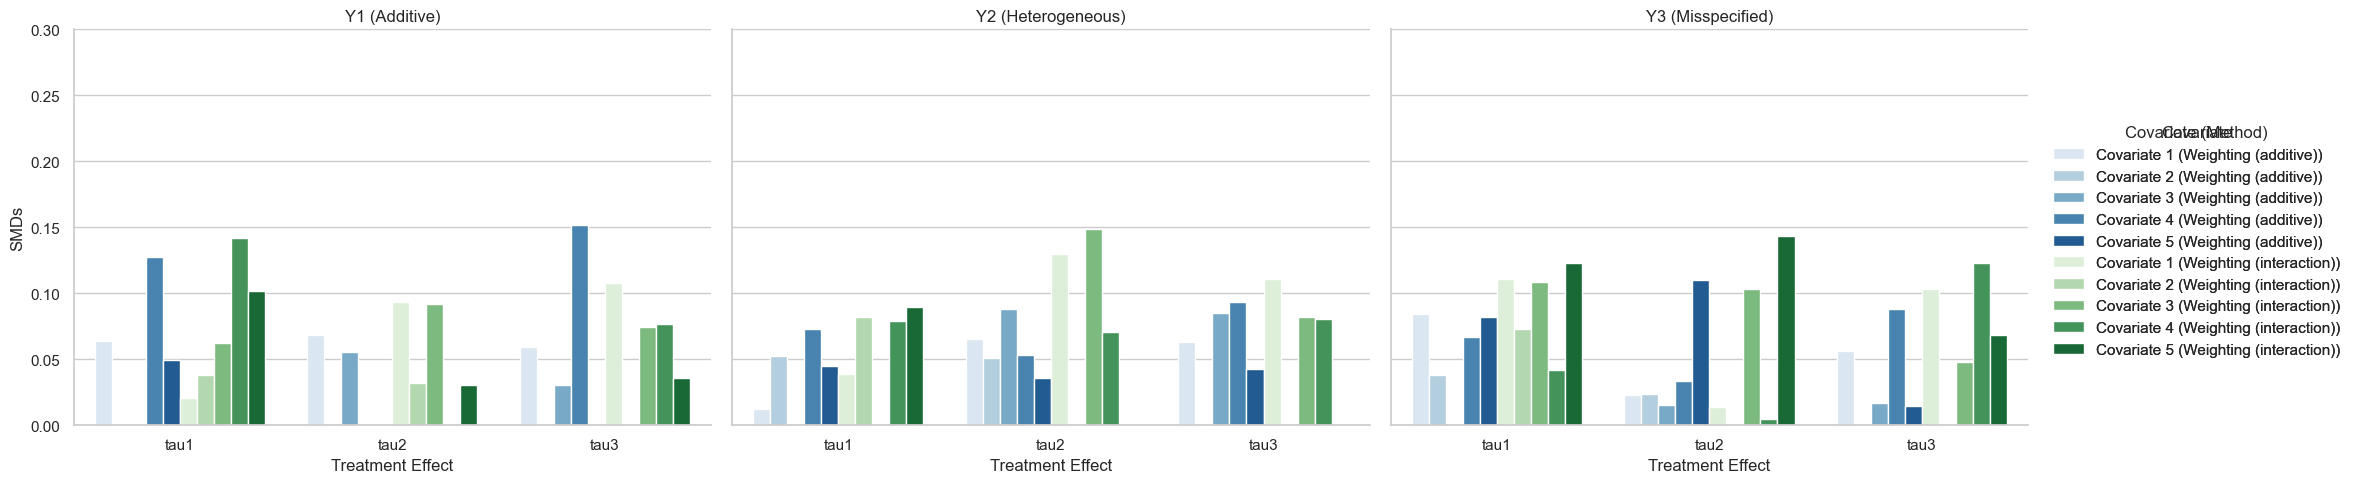

In [5]:
def plot_SMDs_comparison_approx(results_dict):
    effects = ['tau1', 'tau2', 'tau3']
    methods = ["mean_smd_add", "mean_smd_het"]
    method_names = ["Weighting (additive)", "Weighting (interaction)"]
    models = {
        "additive": "Y1 (Additive)",
        "heterogeneous": "Y2 (Heterogeneous)",
        "misspecified": "Y3 (Misspecified)"
    }

    colors_additive = sns.color_palette("Blues", 5)  # 5 colors for additive covariates
    colors_interaction = sns.color_palette("Greens", 5)  # 5 colors for interaction covariates
    color_dict = {}

    data = []

    for model_type, results in results_dict.items():
        for method, method_name in zip(methods, method_names):
            smd_values = results[method]  # Extract SMD values (should be (3,5) per outcome model)
            
            if smd_values.ndim == 2:
                n_effects, n_covariates = smd_values.shape
            else:
                raise ValueError(f"Unexpected SMD shape: {smd_values.shape}")

            for effect_idx in range(n_effects):  # Iterate over tau1, tau2, tau3
                effect_name = effects[effect_idx]
                for covariate_idx in range(n_covariates):  # Iterate over 5 covariates
                    covariate_label = f"Covariate {covariate_idx + 1} ({method_name})"
                    smd_value = smd_values[effect_idx, covariate_idx]
                    data.append([models[model_type], effect_name, smd_value, covariate_label])

                    # Assign colors separately for additive and interaction methods
                    if method_name == "Weighting (additive)":
                        color_dict[covariate_label] = colors_additive[covariate_idx]
                    else:
                        color_dict[covariate_label] = colors_interaction[covariate_idx]

    # Create DataFrame
    df = pd.DataFrame(data, columns=["Outcome Model", "Effect", "SMDs", "Covariate"])

    # Convert categorical columns
    df["Covariate"] = df["Covariate"].astype(str)

    sns.set(style="whitegrid")

    # Create grouped bar plot
    g = sns.catplot(
        data=df,
        x="Effect",
        y="SMDs",
        hue="Covariate",  # 10 colors (5 additive, 5 interaction)
        col="Outcome Model",
        kind="bar",
        palette=color_dict,  # Assigning the correct color mapping
        height=5,
        aspect=1.2
    )

    g.set_axis_labels("Treatment Effect", "SMDs")
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=0)
    g.add_legend(title="Covariate (Method)")
    g.set(ylim=(0, 0.3))  # Adjust limits if necessary

    plt.show()
    
plot_SMDs_comparison_approx(simulation_results_dict)

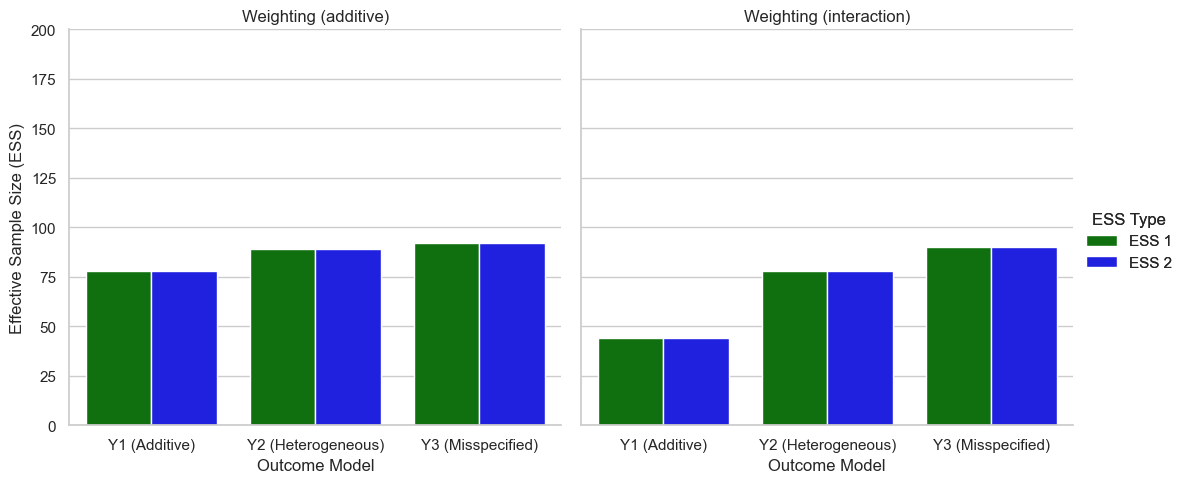

In [6]:
def plot_selected_sample_size(results_dict):
    methods = ["ess_add", "ess_het"]
    method_names = ["Weighting (additive)", "Weighting (interaction)"]
    models = {
        "additive": "Y1 (Additive)",
        "heterogeneous": "Y2 (Heterogeneous)",
        "misspecified": "Y3 (Misspecified)"
    }

    data = []

    for model_type, results in results_dict.items():
        for method, method_name in zip(methods, method_names):
            ess_values = results[method]  # Extract ESS values

            # Ensure ESS values are treated as individual points
            if isinstance(ess_values, np.ndarray):
                ess_values = ess_values.flatten()  # Flatten if it's multidimensional
            
            # Compute the two values of ESS (e.g., first and last, min and max)
            ess_1 = np.min(ess_values)  # First value (or min)
            ess_2 = np.max(ess_values)  # Second value (or max)
            
            #print(f"Effective sample size ({method_name}): {ess_1:.1f}, {ess_2:.1f}")

            # Append two values for each method
            data.append([models[model_type], ess_1, method_name, "ESS 1"])
            data.append([models[model_type], ess_2, method_name, "ESS 2"])

    df = pd.DataFrame(data, columns=["Outcome Model", "ESS", "Method", "ESS Type"])

    # Ensure ESS is numeric
    df["ESS"] = pd.to_numeric(df["ESS"], errors='coerce')

    sns.set(style="whitegrid")

    # Create bar plot with two bars per method
    g = sns.catplot(
        data=df,
        x="Outcome Model",
        y="ESS",
        hue="ESS Type",
        col="Method",
        kind="bar",
        palette=['green', 'blue'],
        height=5,
        aspect=1
    )


    g.set_axis_labels("Outcome Model", "Effective Sample Size (ESS)")
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=0)
    g.add_legend(title="ESS Type")
    g.set(ylim=(0, 200))  # Adjust limits if necessary

    plt.show()

plot_selected_sample_size(simulation_results_dict)

## Setup 2

### Method 1


I clustered the selected units (weight = 1) into matched sets by using a facility‐location formulation. In this formulation, I designate a unit as the representative of a matched set and assign every other unit to one of these facilities. The cost for assigning unit j to facility i is the Mahalanobis distance between their covariate vectors. In addition, I added a term in the objective to to encourage forming more matched sets so that I'm are not forced into one giant matched set.

The key idea in Zubizarreta’s paper is to set covariate balance directly into the matching formulation rather than relying only on minimizing pairwise distances. The setting already have a subset of selected units (weight = 1) and I want to form matched sets based on Mahalanobis distances, so I extended the matching MIP to include additional constraints that target specific imbalance measures (e.g., differences in covariate means).

Taken the ideas from the Zubizarreta’s paper, I penalize imbalances in key covariate moments directly in the objective function. For instance, for each potential matched set (cluster):

• Compute the cluster’s (weighted) average of each covariate.

• Compare it to the overall mean for that covariate in your selected subset.

• Introduce auxiliary variables to capture the absolute difference (imbalance) between the cluster mean and the target.

• Add to objective a weighted sum of these imbalance measures (with weights chosen based on how much imbalance I want to penalize).

Thus, the MIP objective becomes something like:

$$
\text{minimize} \quad \sum_{(i,j)} d_{(i,j)} \cdot x_{(i,j)} - \gamma \sum_i y_i + \sum_{(i,k)} \omega_k \cdot z_{(i,k)}
$$

where:

- $ x_{(i,j)} = 1$ if unit $j$ is assigned to facility $i$;
- $y_i = 1$ if unit $i$ is chosen as a cluster center;
- $ d_{(i,j)} $ is the Mahalanobis distance between units $i$ and $j$;
- For each cluster $i$ and each covariate $k$, $ z_{(i,k)} $ is an auxiliary variable that (after linearization)  
  measures the absolute deviation of the cluster mean for covariate $k$ from the overall mean;
- $\omega_k $ are the weights penalizing imbalance in each covariate.

This formulation directly "targets" the covariate balance, which it no longer relying solely on minimizing distances (which may not guarantee balanced covariate distributions). Instead, by adjusting $\gamma$ and the $\omega_k$'s you explicitly trade off between having many tight clusters (minimizing distances) and achieving balanced matched sets (minimizing imbalances).


In [6]:
def solve_matching_facility(X, gamma=0.3, w_balance=None):
    n, p = X.shape
    if w_balance is None:
        w_balance = np.full(p, 5.0)  # Lower penalty weight
    
    # Compute Mahalanobis distance matrix
    covX = np.cov(X.T)
    inv_covX = np.linalg.inv(covX)
    d_matrix = cdist(X, X, metric='mahalanobis', VI=inv_covX)
    
    BigM = 1e6  # Increased BigM constant
    model = gp.Model("FacilityLocationMatching_Balance")
    model.setParam('OutputFlag', 0)  # set to 1 for more solver output (for debugging)
    model.setParam('TimeLimit', 60)    # allow 60 seconds
    
    # Decision variables
    y = {i: model.addVar(vtype=GRB.BINARY, name=f"y_{i}") for i in range(n)}
    x = {(i,j): model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}") for i in range(n) for j in range(n)}
    
    # Auxiliary variables:
    S = {i: model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"S_{i}") for i in range(n)}
    T = {(i, k): model.addVar(vtype=GRB.CONTINUOUS, name=f"T_{i}_{k}") for i in range(n) for k in range(p)}
    z = {(i, k): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"z_{i}_{k}") for i in range(n) for k in range(p)}
    model.update()
    
    # Each unit j must be assigned to exactly one facility.
    for j in range(n):
        model.addConstr(gp.quicksum(x[(i,j)] for i in range(n)) == 1, name=f"assign_{j}")
    # A unit j can be assigned only if facility i is open.
    for i in range(n):
        for j in range(n):
            model.addConstr(x[(i,j)] <= y[i], name=f"link_{i}_{j}")
    # Define S[i] and T[i,k]
    for i in range(n):
        model.addConstr(S[i] == gp.quicksum(x[(i,j)] for j in range(n)), name=f"Sdef_{i}")
        for k in range(p):
            model.addConstr(T[(i,k)] == gp.quicksum(X[j,k]*x[(i,j)] for j in range(n)), name=f"Tdef_{i}_{k}")
    # Define imbalance variables: difference between total covariate sum in cluster and (global mean * cluster size)
    M = np.mean(X, axis=0)
    for i in range(n):
        for k in range(p):
            model.addConstr(z[(i,k)] >= T[(i,k)] - M[k]*S[i], name=f"imbalance_pos_{i}_{k}")
            model.addConstr(z[(i,k)] >= -(T[(i,k)] - M[k]*S[i]), name=f"imbalance_neg_{i}_{k}")
            model.addConstr(z[(i,k)] <= BigM * y[i], name=f"z_link_{i}_{k}")
    
    # Objective: assignment costs + imbalance penalties - reward for opening facilities
    obj_distance = gp.quicksum(d_matrix[i,j]*x[(i,j)] for i in range(n) for j in range(n))
    obj_balance = gp.quicksum(w_balance[k]*z[(i,k)] for i in range(n) for k in range(p))
    obj_cluster = - gamma * gp.quicksum(y[i] for i in range(n))
    model.setObjective(obj_distance + obj_balance + obj_cluster, GRB.MINIMIZE)
    
    model.optimize()
    print("Gurobi status:", model.status)
    if model.solCount == 0:
        print("Facility matching did not find any feasible solution.")
        return {}
    
    # Retrieve solution values.
    y_sol = model.getAttr('X', y)
    x_sol = model.getAttr('X', x)
    
    clusters = {}
    for i in range(n):
        if y_sol[i] > 0.5:
            clusters[i] = []
    for j in range(n):
        for i in range(n):
            if x_sol[(i,j)] > 0.5:
                clusters[i].append(j)
                break  # each unit j is assigned to exactly one facility
    return clusters


def run_simulation_matching(n_sims=50, N=200, model_type="additive", tol_add=0.05, tol_het=0.05, gamma_fac=0.5):
    simulation_results = []
    
    for sim in range(n_sims):
        # Generate data
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        Z_ = generate_treatments(Xraw)
        Y_ = simulate_Y(Xraw, Z_, model=model_type)
        
        # Obtain binary match vectors from additive and heterogeneous methods.
        matchA = solve_matching_additive(Xraw, Z_, tol=tol_add)
        matchH = solve_matching_heterogeneous(Xraw, Z_, tol=tol_het)
        
        print(f"Simulation {sim+1}:")
        print("Additive match vector (1 = selected):", matchA)
        print("Heterogeneous match vector (1 = selected):", matchH)
        
        # Facility matching for additive selection:
        clusters_A = {}
        selected_indices_A = np.atleast_1d(matchA).nonzero()[0] if matchA is not None else np.array([])
        if len(selected_indices_A) > 0:
            X_selected_A = Xraw[selected_indices_A, :]
            clusters_A = solve_matching_facility(X_selected_A, gamma=gamma_fac)
            print("Matched Sets for Additive Selection (sub-sample indices):")
            for center, members in clusters_A.items():
                if members:  # only show non-empty clusters
                    print(f"Facility (Cluster center) {center}: members {members}")
            # if clusters_A and any(len(members) > 0 for members in clusters_A.values()):
            #     plot_clusters(X_selected_A, clusters_A)
        else:
            print("No units selected by additive matching; skipping facility matching for additive.")
        
        # Facility matching for heterogeneous selection:
        clusters_H = {}
        selected_indices_H = np.atleast_1d(matchH).nonzero()[0] if matchH is not None else np.array([])
        if len(selected_indices_H) > 0:
            X_selected_H = Xraw[selected_indices_H, :]
            clusters_H = solve_matching_facility(X_selected_H, gamma=gamma_fac)
            print("Matched Sets for Heterogeneous Selection (sub-sample indices):")
            for center, members in clusters_H.items():
                if members:  # only show non-empty clusters
                    print(f"Facility (Cluster center) {center}: members {members}")
            # if clusters_H and any(len(members) > 0 for members in clusters_H.values()):
            #     plot_clusters(X_selected_H, clusters_H)
        else:
            print("No units selected by heterogeneous matching; skipping facility matching for heterogeneous.")
        
        print("--------")
        
        simulation_results.append({
            "X": Xraw,
            "Z": Z_,
            "Y": Y_,
            "matchA": matchA,
            "matchH": matchH,
            "selected_indices_A": selected_indices_A,
            "clusters_A": clusters_A,   # clusters from additive selection (sub-sample indices)
            "selected_indices_H": selected_indices_H,
            "clusters_H": clusters_H,   # clusters from heterogeneous selection (sub-sample indices)
        })
        
    return simulation_results


In [3]:
if __name__ == "__main__":
    simulation_results_dict = {}
    for mtype in ["additive", "heterogeneous", "misspecified"]:
        print(f"\n========== Running simulation for model type: {mtype} ==========")
        all_results = run_simulation_matching(n_sims=50, N=200, model_type=mtype, tol_add=0.03, tol_het=0.08, gamma_fac=0.1)
        simulation_results_dict[mtype] = all_results



========== Running simulation for model type: additive ==========
Set parameter Username
Set parameter LicenseID to value 2622621
Academic license - for non-commercial use only - expires 2026-02-16
Simulation 1:
Additive match vector (1 = selected): None
Heterogeneous match vector (1 = selected): [-0.  1.  1. -0.  1.  1.  1.  1.  1. -0.  1. -0.  1.  1. -0.  1. -0. -0.
 -0.  1.  0.  1.  1. -0. -0.  1. -0. -0.  1.  1. -0.  0.  1.  1. -0.  1.
  1.  0.  1. -0.  1. -0.  1.  1. -0. -0. -0.  1.  1.  1.  1. -0.  1. -0.
  1.  1. -0.  1.  1.  1.  1.  1. -0.  1. -0.  1.  1. -0.  0.  1. -0. -0.
  1.  1. -0.  1.  1.  1. -0.  1. -0.  1.  1. -0. -0.  1.  1. -0.  1.  1.
 -0. -0.  1. -0.  0. -0. -0. -0. -0.  1. -0.  1.  1.  1. -0.  1.  1.  1.
 -0.  1.  1. -0. -0. -0. -0. -0.  1.  1. -0.  1.  1.  1.  1.  1.  1.  1.
 -0. -0. -0.  1.  1.  1.  1. -0.  1.  1.  1.  1. -0.  1.  1. -0.  1.  1.
  1. -0.  1.  1.  1.  1. -0.  1. -0. -0.  1.  1. -0. -0.  0.  1.  1.  1.
 -0. -0.  1.  1.  1.  1. -0.  1.  1.  0.  1.